# Image Processing: image mosaïcking

### Admans Léandre
2A - Phelma - SICOM

The aim is to create a simple mosaique of a Target picture using images from the Patches directory.

The chosen algorithm cuts the Target picture into sub-blocks, computes the mean value of each sub-block, and replaces it with the Patch image with the closes mean value.

In [1]:
# General imports
import skimage as sk
import skimage.io as skio
import numpy as np
from os.path import join
import skimage.filters as skf
import skimage.transform as skt
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Dict


plt.rcParams['image.cmap'] = 'gray'

# Path definition
Patchpath = Path.cwd() / "Patches"
Targetpath = Path.cwd() / "Targets"

# Definition du noms des target
Targets_names = ['lions', 'mountain', 'NewYork', 'Rainbow', 'road']

# Declaration du nombre de patch dans le dossier 'Patches'
PATCH_NUMBER = 2687

Extraction de l'image cible souhaitée


Extracting one picture
road has dimensions: (832, 1280, 3)


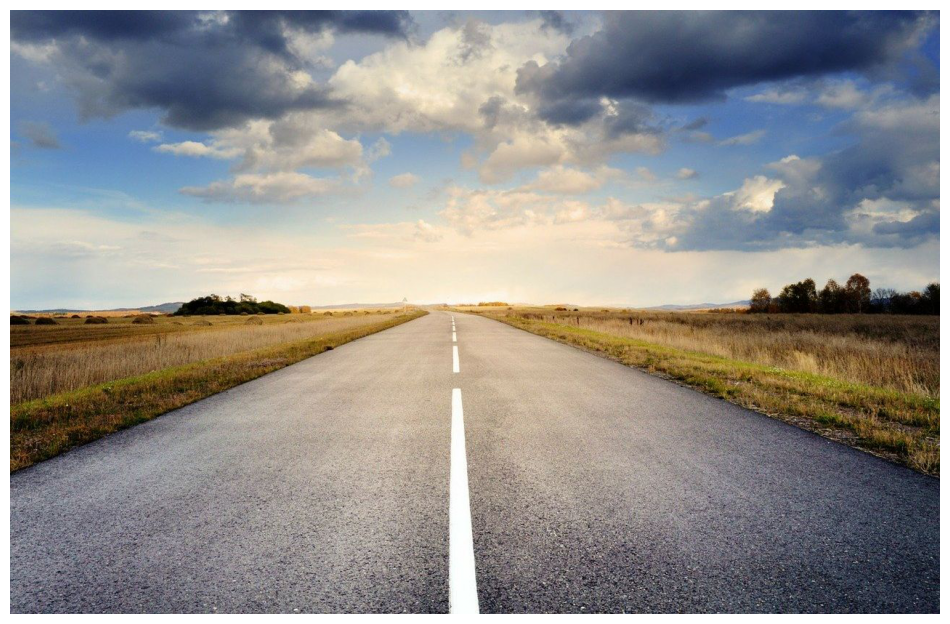

In [2]:
def extract_target(target_number, do_prints=1):
    """
    Parameters: 
    - targer_number : integer bewteen 0 and 4 corresponding
      to the index of the desired image in 'Target_names' list.
    - do_prints=1 : prints size and shows extracted picture if = 1, else not.
    Returns: the extracted image in float format. (default: 1)
    """
    filename = Targets_names[target_number]
    filepath = Targetpath / f"{filename}.jpg"
    img = skio.imread(filepath)
    img = sk.img_as_float(img)
    if do_prints == 1:
      print(f"{filename} has dimensions:", img.shape)
      plt.figure(figsize=(12,8))
      plt.imshow(img)
      plt.axis('off')
      plt.show()
    return img

# extract_target example of use
print("\nExtracting one picture")
target = extract_target(4)  # Extraction of picture 0: 'lions'

The first operation consists in cutting up the target image into small sub-blocks and computing the mean value of each sub-block.

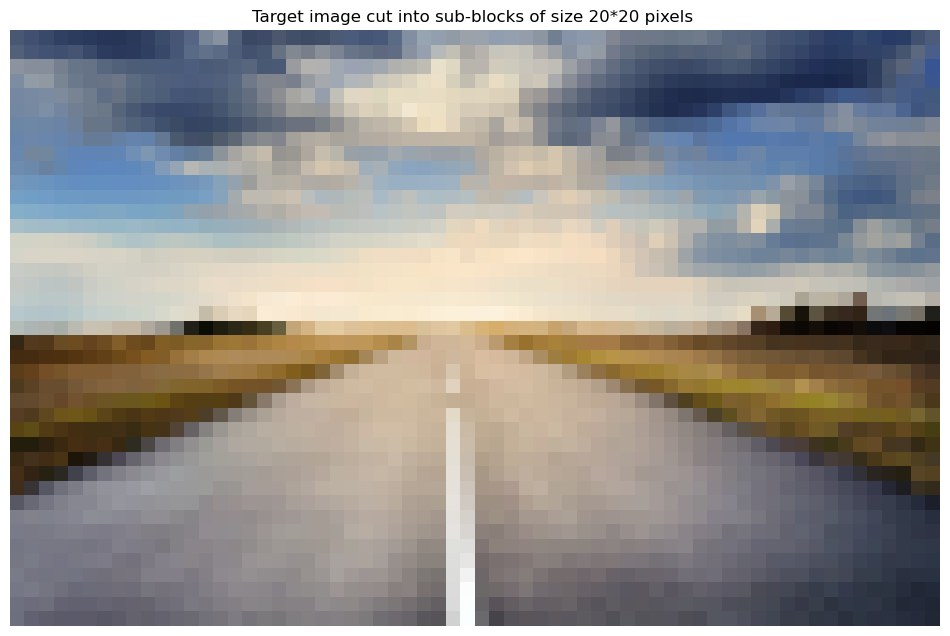

In [3]:
def target_mean(target_img, mean_size=50, do_prints=1):
    """
    Description : cuts 'target_img' into sub-blocks of size 'mean_size'
    and computes the RGB average of each sub-block. 

    Parameters : 
    - target_img : RGB image to be cut into sub-blocks
    - mean_size : size of each sub-block. (default: 50)
    - do_prints : prints size and shows extracted picture if = 1, else not.
    
    Returns: the picture containing the average values. (default: 1)
    """
    
    t_size = target_img.shape
    
    resized_img = target_img[:t_size[0]-t_size[0]%mean_size,:t_size[1]-t_size[1]%mean_size]
    
    size = resized_img.shape
    h_blocks = int(size[0]/mean_size)
    v_blocks = int(size[1]/mean_size)

    meaned_img = np.zeros([h_blocks, v_blocks, 3])
    for i in range(h_blocks):
        i_max = (i+1)*mean_size

        for j in range(v_blocks):
            j_max = (j+1)*mean_size
            
            block_mean = np.mean(target_img[i*mean_size:i_max,j*mean_size:j_max], (0,1))
            meaned_img[i,j,:] = block_mean
    if do_prints:
        plt.figure(figsize=(12,8))
        plt.imshow(meaned_img)
        plt.title(f"Target image cut into sub-blocks of size {mean_size}*{mean_size} pixels ")
        plt.axis('off')
        plt.show()
    return meaned_img
  
# Example:
meaned = target_mean(target, 20) # Block size of 20

The second step consists in storing the RGB mean values of all patches in a dictionnary.

The 'extract_patches_select' function enables the user to select a specific number of patches. This is useful to visualise the effect of the number of available patches to create a mosaique.

This step takes a lot of time since it computes mean value of 2687 images of size (256*256).

In [4]:
def extract_patches_select(n_patches):
    """
    Description: extracts and computes average over 'n_patches' patches
    from the folder Patchpath. 

    Parameters: 
    - n_patches: integer defining how many patch pictures to extract and average.
    
    Returns: Dictionnary associating file path and RGB mean value.
    """

    if n_patches > PATCH_NUMBER : n_patches = PATCH_NUMBER
    
    path_images_dir: Path = Patchpath
    
    mean_by_path: Dict[Path, np.ndarray] = {
    path_images_dir / f"{filenumber}.jpg": 
        sk.img_as_float(skio.imread(path_images_dir / f"{filenumber}.jpg")).mean((0,1))
    for filenumber in range(1, n_patches+2)
    }

    return mean_by_path
# mean_by_path = extract_patches_select(100)

def extract_patches():
    """
    Description: extracts and computes average over all patches
    from the folder Patchpath. 

    Returns: Dictionnary associating file path and RGB mean value.
    """
    path_images_dir: Path = Patchpath
    
    mean_by_path: Dict[Path, np.ndarray] = {
    path_file: sk.img_as_float(skio.imread(path_file)).mean((0,1))
    for path_file in path_images_dir.iterdir()
    }

    return mean_by_path
mean_by_path = extract_patches()

The next function will fetch the patch with the closes mean value to the target picture sub-block.
It uses a quadratic loss function (euclidian norm).

In [5]:
def get_best_patch(color_vect, mean_dict):
    """
    Description: computes distance between 'color_vect' and all the vectors
    in dictionnary 'mean_dict' and returns dictionnary key to value minimising
    distance.
    """
    best_key = Patchpath / "1.jpg"
    best_norm = np.linalg.norm(mean_dict[best_key] - color_vect)
    
    for key in mean_dict.keys():
        if (
                np.linalg.norm(mean_dict[key] - color_vect) < 
                best_norm
        ):
            best_key = key
            best_norm = np.linalg.norm(mean_dict[best_key] - color_vect)
    return best_key

The 'mosaique' function puts all of the previous functions together to generate a mosaique.

This function can take a few minutes to finish depending on the size of the sub-blocks and the amount of available patches.

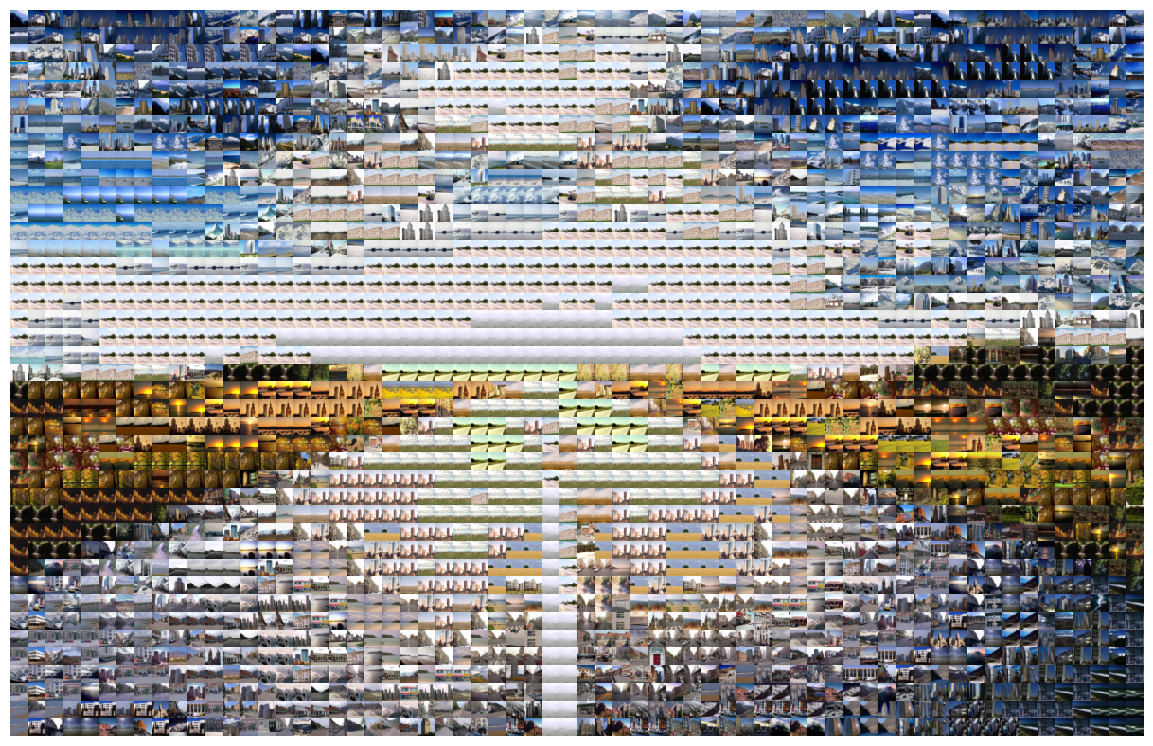

In [6]:
def mosaique(meaned_img, mean_dict, patch_size):
    if patch_size > 256: patch_size = 256
    size = meaned_img.shape
    mosaique_img = np.zeros([size[0]*patch_size, size[1]*patch_size, size[2]])
    
    for i in range(size[0]):
        for j in range(size[1]):
            
            filepath = get_best_patch(meaned_img[i,j], mean_dict)
            patch = skio.imread(filepath)
            patch = sk.img_as_float(patch)
            patch = skt.resize(patch, [patch_size, patch_size])

            mosaique_img[i*patch_size:(i+1)*patch_size,
                         j*patch_size:(j+1)*patch_size,:] = patch

    plt.figure(figsize=(12,8))
    skio.imshow(mosaique_img)
    plt.axis('off')
    plt.show()

    return mosaique_img
mosaique_img = mosaique(meaned, mean_by_path, 20)